## Image Analysis

### Ways of representing an image (or color) as a number
- __Binary__: Each pixel has a value of 0 or 1 (black or white)
- __grayscale__: Each pixel has a value between 0 and 255 (black is 0 white is 255) Each pixel has 8-bits of data ($2^8$)
- __RGB__: storing a value for each pixel as three component colors - Red, Green, Blue
Each pixel has three 8 bit values. All colors combined corresponds to white
- __CMYK__: Uses Cyan - Magenta - Yellow and combining colors makes Black (this is used more for printing)

![colors](images/colors.png)

__But__ CMYK is a subset of RGB, so you cant always print what is on the screen

![colors2](images/colors2.png)

Source: https://www.mgxcopy.com/blog/san-diego-printing/2012/05/01/rgb-vs-cmyk-colorspace-why-its-important-to-use-cmyk-for-printing

One simple way of transforming from CMY to RGB:<br>
C = 255 - R<br>
M = 255 - G<br>
Y = 255 - B<br>

#### Hue, Saturation, Intensity (or lightness)

Another way of representing colors with three numbers

![hue_sat_ints](images/hue_sat_ints.png)


## Image analysis and convolution

### An example in Python

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
file = 'images/squid.jpg'
pic = Image.open(file,'r')

In [3]:
print('W:',pic.width)
print('H:',pic.height)

W: 4033
H: 2342


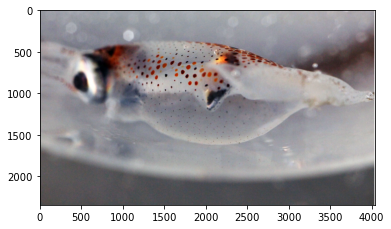

In [4]:
plt.figure()
plt.imshow(pic)

In [5]:
print(pic.format)
print(pic.size)
print(pic.mode)

JPEG
(4033, 2342)
RGB


### Color transformations

The image can be thought of as a three-dimensional matrix, with a value for each x-position, y-position and RGB colors.

In [6]:
print(np.shape(pic))

(2342, 4033, 3)


Multiplying the image matrix by a 3 $\times$ 3 matrix can be used to transfer the values from one color to another.

| |R|G|B|
|-|-|-|-|
|R| | | |
|G| | | |
|B| | | |


In [7]:
parr = np.asarray(pic)
np.shape(parr)
transform = np.array(([1,0,0],
                      [0,0,1],
                      [0,1,0]))

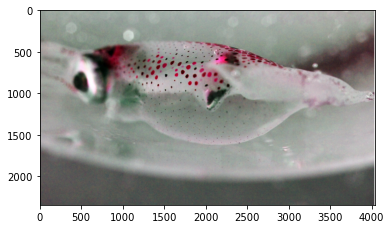

In [8]:
ptrans = np.dot(parr,transform)
plt.figure()
plt.imshow(ptrans)

In [9]:
parr = np.asarray(pic)
np.shape(parr)
transform = np.array(([0,1,0],
                      [1,0,0],
                      [0,0,1])) 

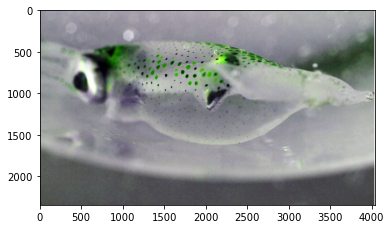

In [10]:
ptrans = np.dot(parr,transform)
plt.figure()
plt.imshow(ptrans)

#### Transform to the negative

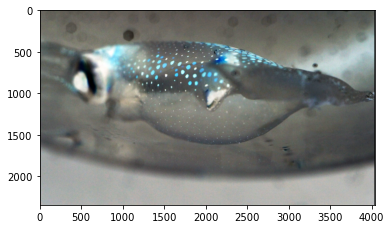

In [11]:
neg = 255 - parr 
plt.figure()
plt.imshow(neg)

#### Transform to Grayscale

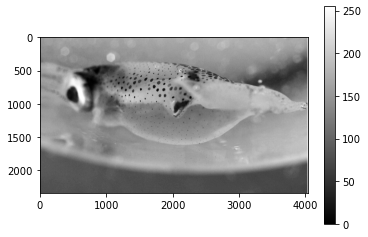

In [12]:
pgray = pic.convert('L')
pgarr = np.asarray(pgray)
plt.figure()
ax = plt.imshow(pgray, cmap='gray')
plt.colorbar()

#### Cropping the image

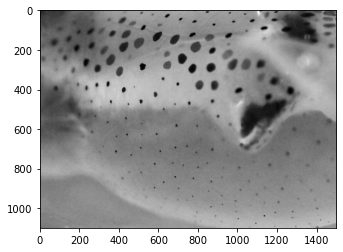

In [13]:
pcrop = pgray.crop(box=(1000,500,2500,1600))
plt.figure()
plt.imshow(pcrop,cmap='gray')

#### Histogram of the grayscale values

(2342, 4033)


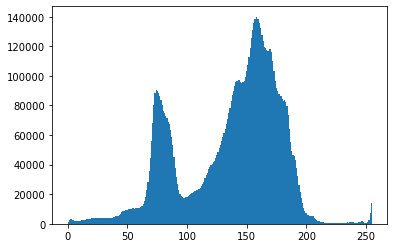

In [14]:
print(np.shape(pgarr))
plt.hist(pgarr.flatten(),bins=256);

#### Gamma corrections
if the original image is $f(x,y)$,

$g(x,y) = c[f(x,y)]^\gamma$

A value of $\gamma$ below 1 shifts the relative distribution of colors towards lighter values.

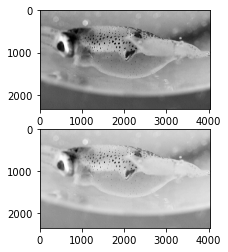

In [15]:
plt.figure(1)
plt.subplot(211)

plt.imshow(pgarr,cmap='gray')
plt.subplot(212)

plt.imshow(pgarr**.5,cmap='gray')
plt.show()

Text(0.5, 1.0, 'gamma corrected')

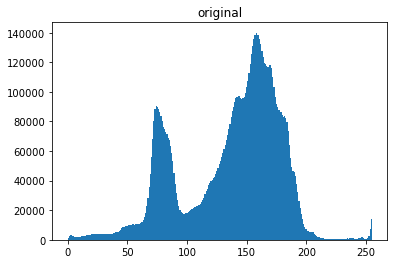

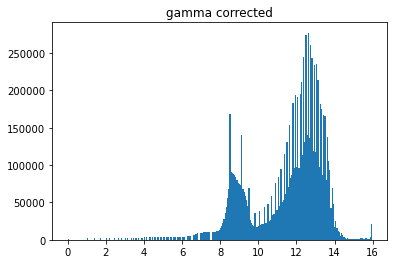

In [16]:
plt.figure()
plt.hist(pgarr.flatten(),bins=256);
plt.title('original')
plt.figure()
plt.hist((pgarr**.5).flatten(),bins=256);
plt.title('gamma corrected')

### Smoothing

As in time series analysis, the simplest filter for a 2D image is a running average of surrounding points in some interval. In this case the filter is 2D. A 3 $\times$ 3 running average can be obtained by convolving the image matrix with this matrix:

| 1 | 1 | 1 |
|---|---|---|
| 1 | 1 | 1 |
| 1 | 1 | 1 |

This can be created in Python using the `np.ones()` function.

In [17]:
filt = np.ones([3,3])
print(filt)

[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]


In [18]:
filtnorm = filt/np.sum(filt)
print(filtnorm)

[[0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]]


Convolution also works in two dimensions.

In [19]:
from scipy.signal import convolve2d
filt = np.ones([50,50])
filtnorm = filt/np.sum(filt)
psmooth = convolve2d(pgarr,filtnorm)

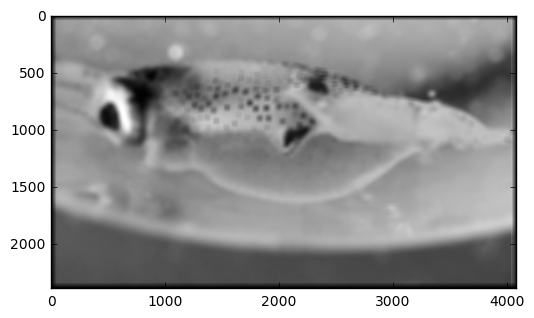

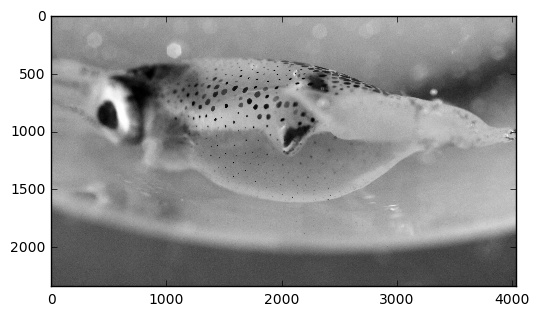

In [27]:
plt.figure()
plt.imshow(psmooth,cmap='gray')
plt.figure()
plt.imshow(pgarr,cmap='gray')

Plotting a horizontal slice of grayscale values in the two images above. There is clearly less small-scale variability in the smoothed version. The smoothed version also has some slightly different features because it is incorporating information from the vertical dimension through the averaging process.

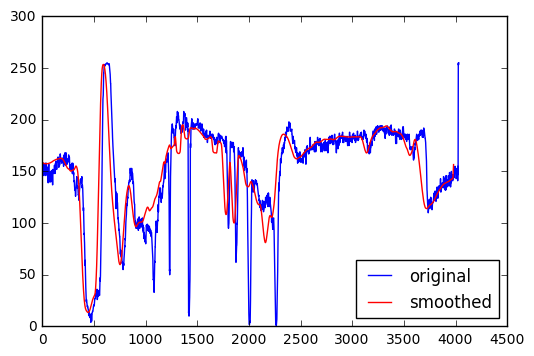

In [29]:
plt.figure()
plt.plot(pgarr[900,:],'b') 
plt.plot(psmooth[900,50:-50],'r') 
plt.legend(['original','smoothed'],loc='best')

### Making monochromatic image from a threshold value

Why smooth an image and lose the detail in the original?

One reason is for detecting features. One way of doing this is to use a threshold value to differentiate regions of different lightness and darkness. Doing this type of analysis on the smoothed version of the image highlights only the larger scale features and less small-scale noise (like near the bottom).

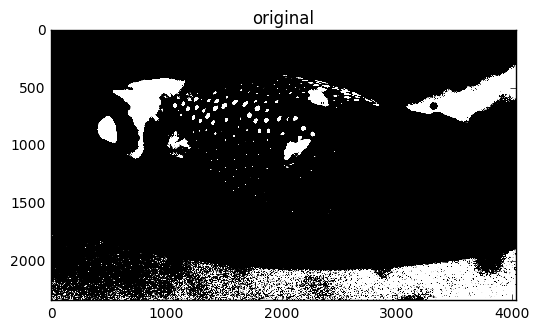

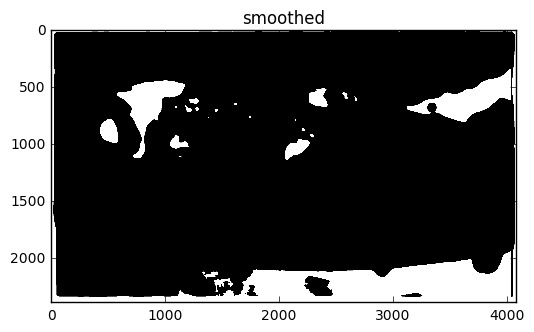

In [32]:
pthresh = pgarr/255 <0.3
plt.figure()
plt.imshow(pthresh,cmap='gray')
plt.title('original')
pthreshs = psmooth/255 <0.3
plt.figure()
plt.imshow(pthreshs,cmap='gray')
plt.title('smoothed')

### Edge Detection 

Detection of edges can be based on how sharp the gradients are (differences in adjacent values).

This requires an estimate of the spatial derivative in both directions ($x$ and $y$). These two components can be estimated from discrete data as:

x derivative (horizontal component) = $\frac{\partial f}{\partial x} \approx \frac{f(x + \Delta x)-f(x - \Delta x)}{2 \Delta x}$ <br>

y derivative (vertical component) = $\frac{\partial f}{\partial y} \approx \frac{f(y + \Delta y)-f(y - \Delta y)}{2 \Delta y}$ <br>

The __gradient vector__ $\nabla f = \left(\frac{\partial f}{\partial x}, \frac{\partial f}{\partial y}\right)$ has both magnitude and direction.

$\left|\nabla f \right| = \sqrt{\left(\frac{\partial f}{\partial x}\right)^2 + \left(\frac{\partial f}{\partial y}\right)^2}$


The $x$ derivative can be computed by convolving the imagae matrix with a matrix for $\frac{\partial}{\partial x}$ in the nearby area.

$$\begin{bmatrix}
-1 & 0 & 1\\
-1 & 0 & 1\\
-1 & 0 & 1
\end{bmatrix}$$


The $y$ derivative can be computed by convolving the imagae matrix with a matrix for $\frac{\partial}{\partial y}$ in the nearby area.

$$\begin{bmatrix}
1 & 1 & 1\\
0 & 0 & 0\\
-1 & -1 & -1
\end{bmatrix}$$

In [1]:
ddx = [[-1,0,1],
       [-1,0,1],
       [-1,0,1]]

ddy = [[-1,-1,-1],
       [0,0,0],
       [1,1,1]]

In [ ]:
dpdx = convolve2d(pcrop,ddx)
dpdy = convolve2d(pcrop,ddy)
pgrad = np.sqrt(dpdx**2 + dpdy**2)

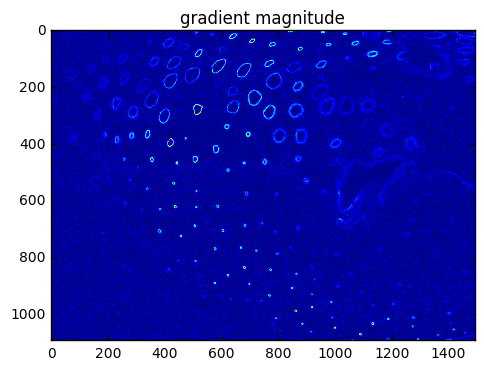

In [34]:
plt.figure()
plt.imshow(pgrad[5:-5,5:-5])
plt.title('gradient magnitude')

#### Sobel filter

This is a commonly-used method for computing gradients that is similar, but gives more weight to nearby points.

$x$ derivative:

$$\begin{bmatrix}
-1 & 0 & 1\\
-2 & 0 & 2\\
-1 & 0 & 1
\end{bmatrix}$$

$y$ derivative:

$$\begin{bmatrix}
1 & 2 & 1\\
0 & 0 & 0\\
-1 & -2 & -1
\end{bmatrix}$$